In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

import numpy as np  
from math import cos, sin, acos, pi
from IPython.core.debugger import Tracer

In [2]:
def radians (array):
    return array*pi/180

In [3]:
# turn euler angle into vector
def euler2Vec (vec3):
    rotx = vec3[0]
    roty = vec3[1]
    rotz = vec3[2]
    x = np.sin(radians(roty))*np.cos(radians(rotx))
    y = -np.sin(radians(rotx))
    z = np.cos(radians(roty))*np.cos(radians(rotx))
    return np.array([x,y,z])

In [25]:
# calculate angle between two vector
def calcAngleDeg (v1,v2):
    # v1*v2/(sqrt(v1*v1)*sqrt(v2*v2))
    costheta = np.sum(np.multiply(v1,v2),axis=1)/(
        np.sqrt(np.sum(np.multiply(v1,v1),axis=1))*
        np.sqrt(np.sum(np.multiply(v2,v2),axis=1)))
    if np.any(abs(costheta)>1):
        print("costheta value wrong:\n")
        print(costheta[(abs(costheta)>1)])
    return 180/pi*np.arccos([min(max(x,-1),1) for x in costheta])

In [18]:
# calculate angular velocity from headvec
# unit: 10*deg/frame
def calcAngleSpeed(headVec):
    headVec_t0 = headVec[:-1]
    headVec_t1 = headVec[1:]
    angleSpeed = calcAngleDeg(headVec_t0,headVec_t1)
    return np.append(angleSpeed*10,0) # pad with 0 to get the same length

In [6]:
# load csv from folders
import os

def loadFiles(root="data/TAIWAN_RAW_DATA/ADHD"):
    data_rt = [] # realtime.csv
    data_trial = [] # trialdata.csv
    RealTime = "A2RealTime_"
    TrialData = "A2TrialData_"
    folder_list = os.listdir(root) # list of subfolders in the root
    for folders in folder_list:
        folders_path = os.path.join(root,folders)
        try:
            data_rt.append(pd.read_csv(os.path.join
                                   (folders_path,
                                   RealTime+folders[3:]+".csv")))
            data_trial.append(pd.read_csv(os.path.join
                                      (folders_path,
                                       TrialData+folders[3:]+".csv")))
        except:
            print(os.path.join(folders_path,TrialData+folders[3:]+".csv"))
            
    return data_rt,data_trial,folder_list


In [8]:
# prepare data
ADHD,ADHD_Trial,tt = loadFiles("data/TAIWAN_RAW_DATA/ADHD")
HEALTHY,HEALTHY_Trial,tt = loadFiles("data/TAIWAN_RAW_DATA/HEALTHY")
SHANGHAI_ADHD,SHANGHAI_ADHD_Trial,tt = loadFiles("data/SHANGHAI_DU/ADHD")
distractXYZName = ['DistracterPosX','DistracterPosY','DistracterPosZ']
XYZName = ['RotX','RotY','RotZ']
PosName = ['PosX','PosY','PosZ']


costheta value wrong:

[ 1.]
costheta value wrong:

[ 1.]


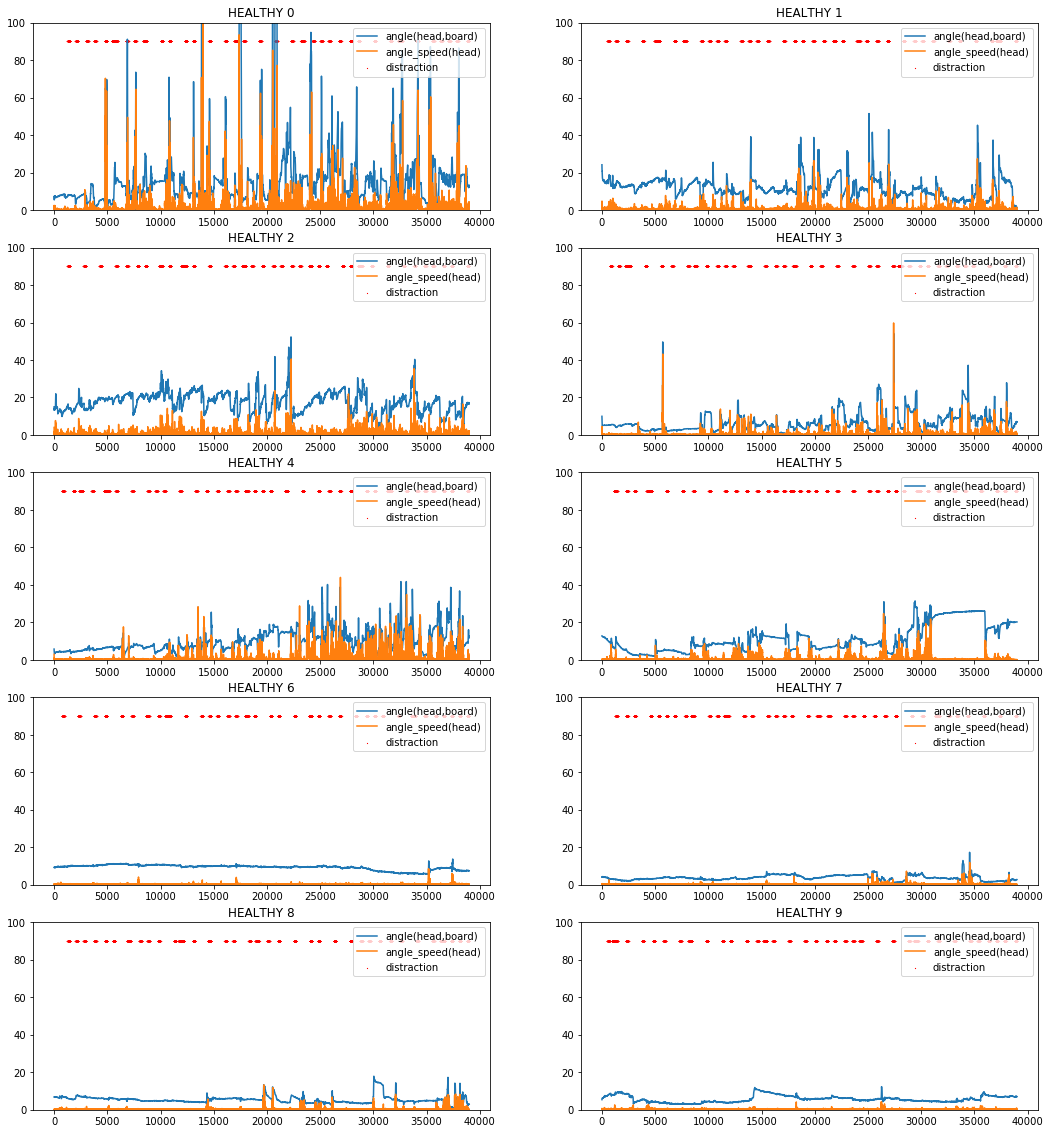

In [29]:
plt.close('all')

tarGroup = HEALTHY
tarTrial = HEALTHY_Trial
fig,subfigs = plt.subplots(5,2,figsize=(18,20))
for i in range(len(tarGroup)):
    ind_distract = pd.notnull(tarGroup[i]['DistracterType'])
    ind_ones = np.ones(ind_distract.shape,dtype='bool')

    healthGazeDistract = np.zeros(np.shape(ind_ones))

    # calculate head vector (oritentation)
    eulerVec = np.array(tarGroup[i][XYZName])
    headVec = euler2Vec(eulerVec.T).T
    
    # get vector to the target (distracter)
    tarVec = np.array(tarGroup[i][distractXYZName])
    # set the blackboard as target, comment it if use distracter as target
    tarVec = np.tile([0,2.03,4.91],[len(eulerVec),1])
    headPos = np.array(tarGroup[i][PosName])
    tarVec = tarVec - headPos
        
    distractType = tarGroup[i]['DistracterType']
    distractName = tarGroup[i]['DistracterName']
    
    # calculate angle and angular speed
    deg = calcAngleDeg(headVec[ind_ones],tarVec[ind_ones])
    deg_speed = calcAngleSpeed(headVec)
#     plt.figure()
#     plt.hist(deg,bins='auto')
#     plt.show()
    
    distractPlot_x = np.where(ind_distract==True)[0]
    distractPlot_y = np.ones(len(distractPlot_x))*90
    subfigs[int(i/2)][i%2].set_title('HEALTHY %d'%i)
    subfigs[int(i/2)][i%2].scatter(distractPlot_x,distractPlot_y,marker='*',s=0.1,c='r',label='distraction')
    subfigs[int(i/2)][i%2].plot(range(len(deg)),deg,label='angle(head,board)')
    subfigs[int(i/2)][i%2].plot(range(len(deg_speed)),deg_speed,label='angle_speed(head)')
    subfigs[int(i/2)][i%2].set_ylim([0,100])
    subfigs[int(i/2)][i%2].legend(loc='upper right')
    
plt.show()

In [ ]:
# draw gif for head and target movement, uncommented yet
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.ticker import MultipleLocator

class Arrow3D(FancyArrowPatch):

    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs
#         Tracer()()
        
        if 'label' in kwargs.keys():
            self.label = kwargs['label']

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
    def set_pos(self,vec3):
        self._verts3d = [0,vec3[0]],[0,vec3[1]],[0,vec3[2]]
        
    def get_vert(self):
#         Tracer()()
#         print(self._verts3d)
        return self._verts3d[0][1],self._verts3d[1][1]
                
    def get_allvert(self):
        return self._verts3d



import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.core.debugger import Tracer
from IPython.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D

def data_gen(t=0):
    cnt = 0
    while cnt < 1000:
        cnt += 1
        t += 0.1
        yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)


def init():
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    ax.view_init(30,-90)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    return arr_head,arr_tar,

# fig, ax = plt.subplots()
plt.close("all")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
arr_head = Arrow3D([0, 1], [0, 1], [0, 0], mutation_scale=20,
            lw=1, arrowstyle="-|>", color="r",label='head orientation')
arr_tar = Arrow3D([0, 1], [0, 1], [0, 1], mutation_scale=20,
            lw=1, arrowstyle="-|>", color="k",label='target vector')
ax.grid()
ax.add_artist(arr_head)
ax.add_artist(arr_tar)

# locator = MultipleLocator(0.2)
# ax.get_xaxis.set_major_locator(MultipleLocator)
# ax.yaxis.set_major_locator(MultipleLocator)
# ax.zaxis.set_major_locator(MultipleLocator)


plt.legend([arr_head,arr_tar],['head orientation','target vector'])
ttl = ax.text(.5, 1.05, 0, 'xxx', transform = ax.transAxes, va='center')
# pt_head = ax.scatter(xs=0,ys=0,label='head')
# pt_tar = ax.scatter(xs=0,ys=1,label='target')
# txt_head = ax.text2D(0,0,'head')
# txt_tar = ax.text2D(0,0,'target')
# ax.annotate('anno',xy = (1,1))
# txt_head.set_position([1,1])

def run(data,arr_head,arr_tar,ttl):
    # update the data
#     %%debug
    global distractType
    hv = data[:3]
    tv = data[3:6]
    tv = tv/np.linalg.norm(tv)
    hv = hv/np.linalg.norm(hv)
    
    frames_cnt = int(data[6])
    noDistract = True
#     distractType.keys??
#     Tracer()()
    if frames_cnt in distractType.index:
#         if distractName[frames_cnt] != distractName[frames_cnt-1]:
        ttl.set_text(distractName[frames_cnt]+', '+distractType[frames_cnt]+', angle: %d'%data[7])
        noDistract = True
    else:
        if noDistract:
            ttl.set_text("no distracter")
        noDistract = False
    
    
#     Tracer()() 
    arr_head.set_pos(hv)
    arr_tar.set_pos(tv)
    
#     Tracer()() 
#     txt_head.set_position(arr_head.get_vert())
#     txt_tar.set_position(arr_tar.get_vert())
#     pt_head.set_paths(paths=arr_head.get_vert()) 
#     arr_head.draw

#     FancyArrowPatch.set_positions(posA=[0,0,0],posB=[hv],self=arr_head)
#     FancyArrowPatch.set_positions(posA=[0,0,0],posB=[tv],self=arr_tar)
    
#     xmin, xmax = ax.get_xlim()
#     if t >= xmax:
#         ax.set_xlim(xmin, 2*xmax)
#         ax.figure.canvas.draw()
#     line.set_data(xdata, ydata)

    return arr_head,arr_tar,

from matplotlib import rc, animation
rc('animation', html='html5')
# %pdb
# ind = ind[500:1000]
len_ind = np.sum(ind==True)
ani = animation.FuncAnimation(fig, run, 
                              np.concatenate((headVec[ind],
                                              tarVec[ind],
                                              np.array(np.where(ind==True)).reshape(len_ind,1),
                                              deg.reshape(len_ind,1)),axis=1)[::4], 
                              blit=True, interval=88,
                              repeat=True, init_func=init,
                              fargs=(arr_head,arr_tar,ttl))

# plt.show()
ani

In [ ]:
ani.save('health_head.mp4', fps=8, extra_args=['-vcodec', 'libx264']) 